# scikit-learnのトレーニング♨

## 様々な分類器（PPN、SVM、DTL、LRA） 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
- [共通的データ処理](#共通的データ処理)
- [モデル・アルゴリズム](#モデル・アルゴリズム)
  - PPN: [パーセプトロン](#単純パーセプトロン線形分類器)
  - SVM: [サポートベクターマシン](#サポートベクターマシン分類器)
  - DTL: [決定木（分類木）](#決定木分析)
  - LRA: [ロジスティクス回帰](#ロジスティック回帰)
- その他
  - [各特徴量の重要度を出力](#各特徴量の重要度を出力)
  - [分類問題の性能の評価](#分類問題の性能の評価)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python#y4054d35

## [環境準備](ScikitLearnTraining0.ipynb)

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets                                 # サンプル・データセット
from sklearn.datasets import make_regression                 # 回帰データセット作成
from sklearn.datasets import make_blobs                      # 分類データセット作成
from sklearn.preprocessing import StandardScaler             # 標準化
from sklearn.model_selection import train_test_split         # データ分割

from sklearn.linear_model import LinearRegression            # 線形回帰
from sklearn.preprocessing import PolynomialFeatures         # 多項式回帰の変数変換
from sklearn.linear_model import Ridge                       # 多項式回帰のRidge回帰
from sklearn.linear_model import Lasso                       # 多項式回帰のLASSO回帰
from sklearn.linear_model import ElasticNet                  # 多項式回帰のLASSO回帰
from sklearn.linear_model import Perceptron                  # 単純パーセプトロン線形分類器
from sklearn.linear_model import LogisticRegression          # ロジスティク回帰
from sklearn.svm import SVC                                  # サポートベクターマシン（SVM）分類器
from sklearn.tree import DecisionTreeClassifier              # 決定木（分類木）
from sklearn.ensemble import RandomForestClassifier          # ランダムフォレスト（分類木）
from sklearn.ensemble import GradientBoostingClassifier      # 勾配ブースティング木（分類木）
from sklearn.decomposition import PCA                        # 主成分分析
from sklearn.cluster import KMeans                           # k-means法 クラスタ分析
from sklearn.feature_extraction.text import CountVectorizer  # 自然言語処理ベクトル化
from sklearn.feature_extraction.text import TfidfTransformer # 自然言語ベクトルのTF-IDF計算
from sklearn.decomposition import LatentDirichletAllocation  # 自然言語ベクトルからLDAトピック抽出

from sklearn import metrics                                  # モデル評価
from sklearn.metrics import mean_squared_error as mse        # 精度評価（mse）
from sklearn.metrics import confusion_matrix                 # 混同行列
from sklearn.metrics import silhouette_samples               # シルエット係数
from sklearn.model_selection import cross_val_score          # 交差検証法
from sklearn.model_selection import KFold                    # k分割交差検証法
from sklearn.model_selection import StratifiedKFold          # 層化交差検証法
from sklearn.model_selection import GridSearchCV             # グリッドサーチ

import seaborn as sns                                        # matplotlibラッパ
from mlxtend.plotting import plot_decision_regions           # 決定領域表示関数
from matplotlib import cm                                    # カラーマップ処理

from numpy import linalg as LA                               # 線形代数ライブラリ

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 共通的データ処理

### 生成

In [3]:
iris = datasets.load_iris()
df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([df_data, df_target], axis=1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### 加工
特になし。

### 理解

#### 基本統計量

In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


#### 相関

##### カテゴリ分類した散布図行列を表示

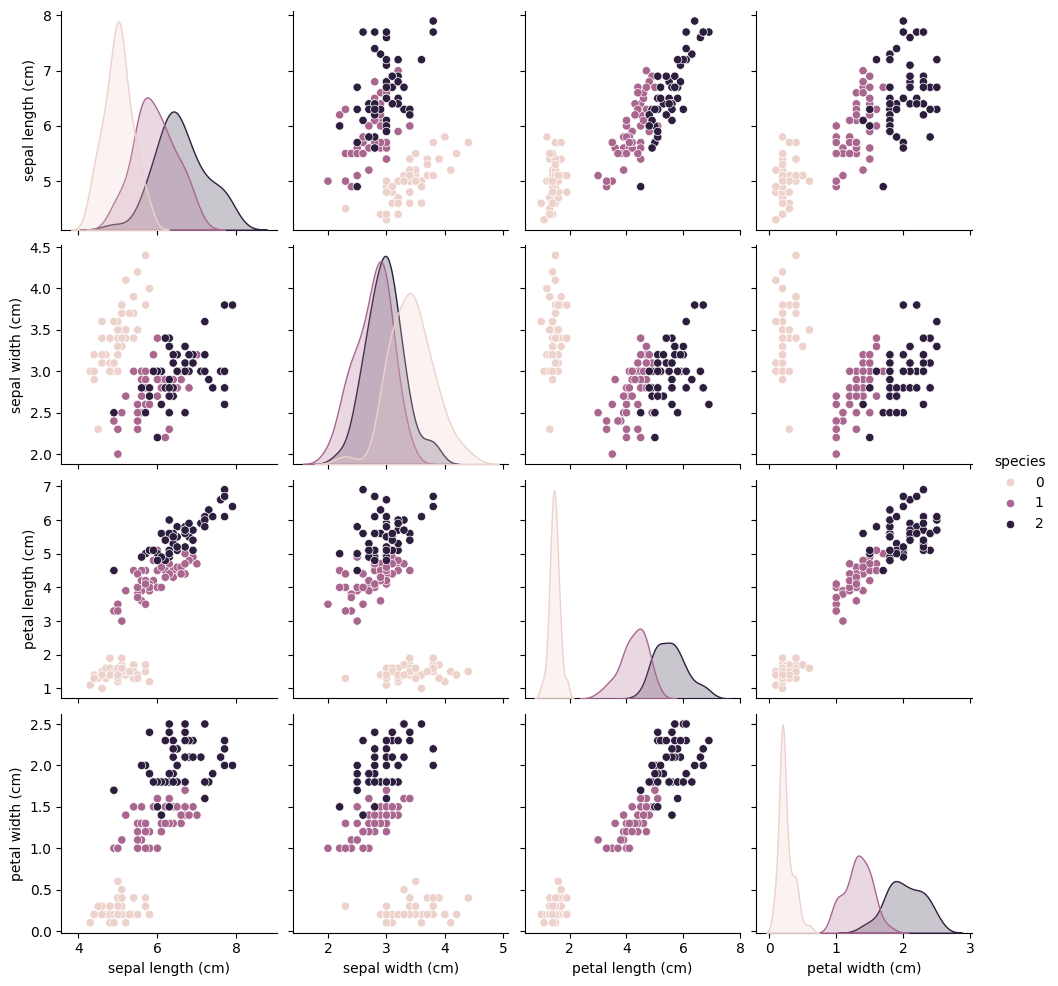

In [5]:
sns.pairplot(df, hue='species')
plt.show()

### 準備

#### 説明変数・目的変数の選択・分割

In [6]:
np_arr=np.array(df)

# n = 100で2値分類
# n = 150で3値分類
n = 150

# PetalLengthCm, PetalWidthCm列の選択
x=np_arr[:n, 2:4] 
# x=np_arr[:n, 0:4] 

# Species列の選択
y=np.array(np_arr[:n, 4:5],dtype=np.int64) # 要素の型をint64に変換

#### 標準化
カテゴリ・データは対象外

In [7]:
ss = StandardScaler()
ss.fit(x)
x_std = ss.transform(x)

#### 学習・テストデータの分割

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=0)

## モデル・アルゴリズム
- ココでは、以下のデータで分類するが、説明変数を増やしても良い。
- ただし、説明変数を2以上に増やすと、平面上で確認ができなくなる。

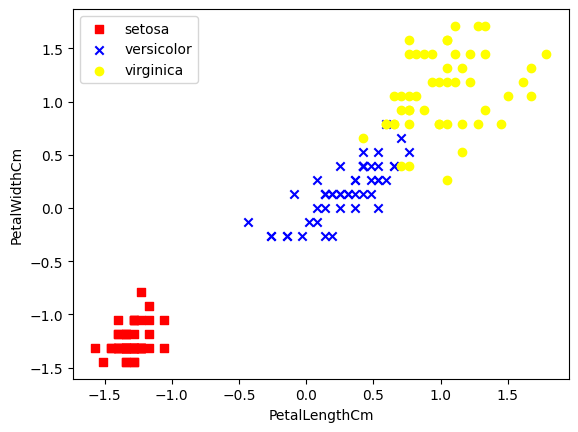

In [9]:
plt.scatter(x_std[:50, 0], x_std[:50,1], color="red", marker="s", label="setosa")
plt.scatter(x_std[50:100, 0], x_std[50:100,1], color="blue", marker="x", label="versicolor")
plt.scatter(x_std[100:150, 0], x_std[100:150,1], color="yellow", marker="o", label="virginica")
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.show()

### 単純パーセプトロン線形分類器
- 単層パーセプトロンだから線形問題しか解けない模様。
- パーセプトロンやニューラルネットワークについては[コチラ](KasagoDL1.ipynb)を参照。

※ [イメージ](https://www.google.com/search?q=単純パーセプトロン線形分類器&tbm=isch)

#### [データ](#共通的データ処理)

#### モデリング

##### 学習

In [10]:
ppn = Perceptron(eta0=0.1) # 学習率 0.1
ppn.fit(x_train, np.reshape(y_train,(-1)))

Perceptron(eta0=0.1)

##### 推論

In [11]:
index = 15
print('answer : %d' % y_test[index][0])
print('predict: %d' % ppn.predict([x_test[index]])[0])

answer : 0
predict: 0


#### 評価

##### データセットの正答率

In [12]:
print('train acc: %.3f' % ppn.score(x_train, y_train))
print('test acc: %.3f' % ppn.score(x_test, y_test))

train acc: 0.952
test acc: 0.978


##### 学習した決定境界を可視化

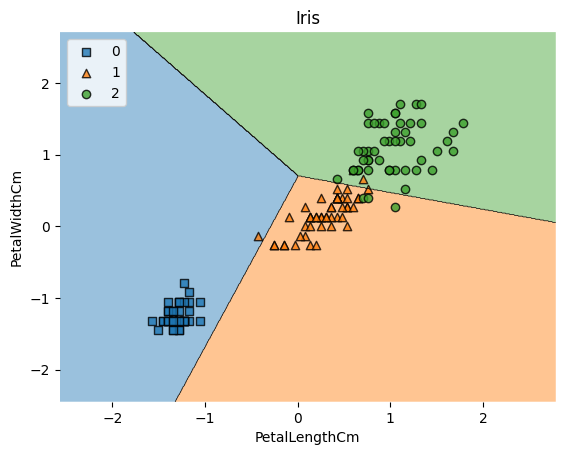

In [13]:
plot_decision_regions(x_std, y.flatten(), ppn)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

### サポートベクターマシン分類器
- ｢分離マージン最大化｣というコンセプトに基いて超平面で分類を実行。
- 非線形の分離にも対応できるという非常に大きな利点がある｡

※ [イメージ](https://www.google.com/search?q=サポートベクターマシン&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#f3322edd)

#### [データ](#共通的データ処理)

#### モデリング

##### 学習

###### 通常

In [14]:
svc = SVC(kernel='linear')
svc.fit(x_train, np.reshape(y_train,(-1))) 

SVC(kernel='linear')

###### スラック変数の導入（誤分類を許容）
C: 誤分類を調整する正則化パラメタ（小は誤分類に寛大、大は誤分類に厳格）

In [15]:
svc1 = SVC(kernel='linear', C=1.0)
svc1.fit(x_train, np.reshape(y_train,(-1))) 

SVC(kernel='linear')

###### カーネル法の導入（非線形対応）
C: 誤分類への厳しさ、gamma: 決定曲線の複雑さ

In [16]:
svc2 = SVC(kernel='rbf', gamma=0.1, C=10)
svc2.fit(x_train, np.reshape(y_train,(-1))) 

SVC(C=10, gamma=0.1)

##### 推論

###### 通常

In [17]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % svc.predict([x_test[index]])[0])

answer : 2
predict: 2


###### スラック変数の導入（誤分類を許容）

In [18]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % svc1.predict([x_test[index]])[0])

answer : 2
predict: 2


###### カーネル法の導入（非線形対応）

In [19]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % svc2.predict([x_test[index]])[0])

answer : 2
predict: 2


#### 評価

##### データセットの正答率

###### 通常

In [20]:
print('train acc: %.3f' % svc.score(x_train, y_train))
print('test acc: %.3f' % svc.score(x_test, y_test))

train acc: 0.952
test acc: 0.978


###### スラック変数の導入（誤分類を許容）

In [21]:
print('train acc: %.3f' % svc1.score(x_train, y_train))
print('test acc: %.3f' % svc1.score(x_test, y_test))

train acc: 0.952
test acc: 0.978


###### カーネル法の導入（非線形対応）

In [22]:
print('train acc: %.3f' % svc2.score(x_train, y_train))
print('test acc: %.3f' % svc2.score(x_test, y_test))

train acc: 0.952
test acc: 0.978


##### 学習した決定境界を可視化

###### 通常

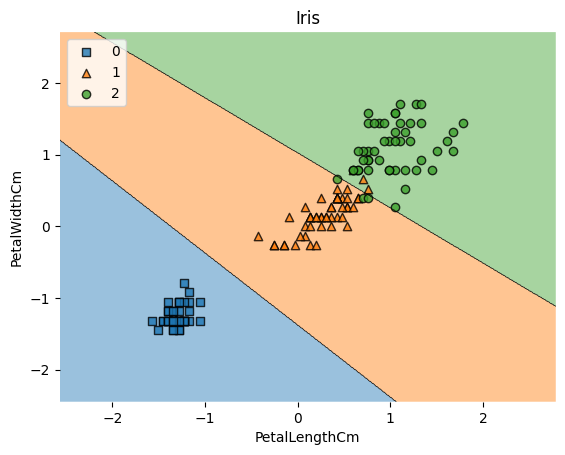

In [23]:
plot_decision_regions(x_std, y.flatten(), svc)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

###### スラック変数の導入（誤分類を許容）

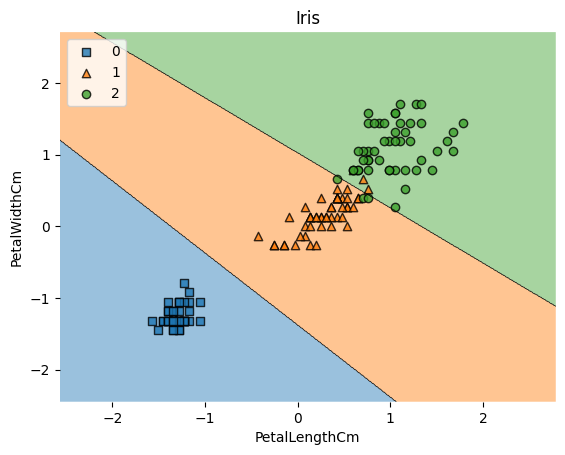

In [24]:
plot_decision_regions(x_std, y.flatten(), svc1)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

###### カーネル法の導入（非線形対応）

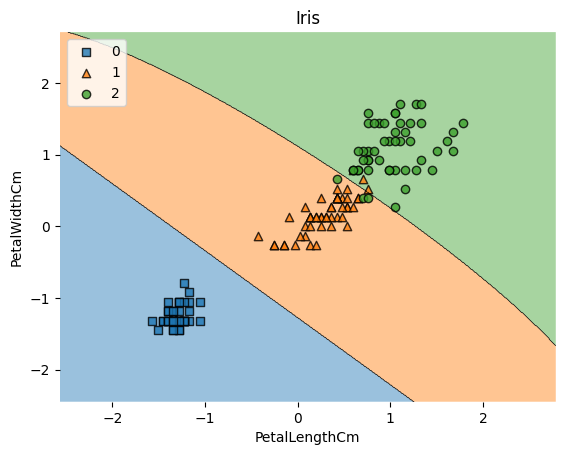

In [25]:
plot_decision_regions(x_std, y.flatten(), svc2)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

##### カーネル法をXORパターンで評価
カーネル法で以下のテストデータを使うと、  
決定境界の非線形性が顕著に可視化される。

###### XORのデータの作成

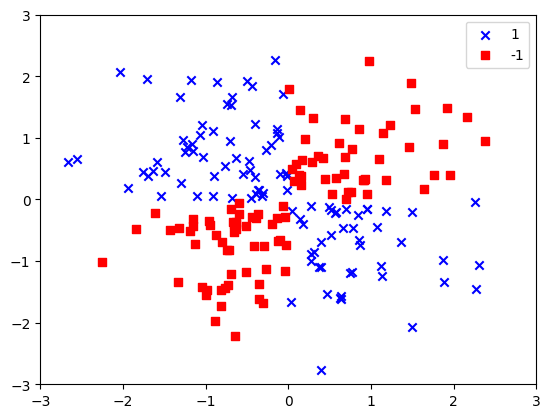

In [26]:
np.random.seed(0)
x_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(x_xor[:, 0] > 0, x_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
# データの散布
plt.scatter(x_xor[y_xor == 1, 0], x_xor[y_xor == 1, 1], c='b', marker='x', label='1')
plt.scatter(x_xor[y_xor == -1, 0], x_xor[y_xor == -1, 1], c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best') # 右上に凡例を出力
plt.show()

###### ホールド・アウト法による学習・テストデータの分割

In [27]:
x_xor_train, x_xor_test, y_xor_train, y_xor_test = train_test_split(x_xor, y_xor, test_size=0.3, random_state=0)

###### カーネルSVMによる学習
C: 誤分類への厳しさ、gamma: 決定曲線の複雑さ

In [28]:
svc3 = SVC(kernel='rbf', gamma=0.1, C=10)
svc3.fit(x_xor_train, y_xor_train)

SVC(C=10, gamma=0.1)

###### 決定曲線のプロット

<Axes: >

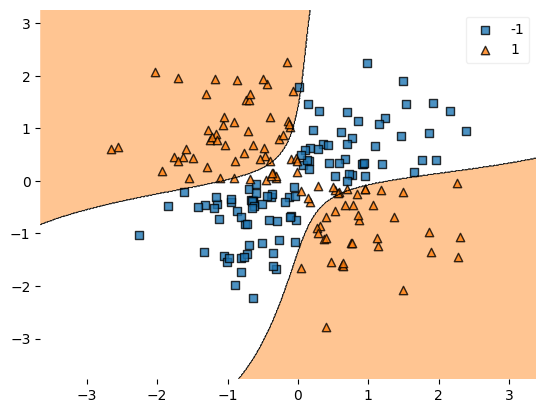

In [29]:
plot_decision_regions(x_xor, y_xor, svc3)

### 決定木分析
決定木（分類木）による分類器で分類

※ [イメージ](https://www.google.com/search?q=決定木（分類木）&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#lcaf7a28)

#### [データ](#共通的データ処理)

#### モデリング

##### 学習

###### 通常

In [30]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

###### 剪定
max_depthを指定

In [31]:
tree_md = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_md.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

###### ランダムフォレスト
n_estimatorsを指定

In [32]:
tree_rfc = RandomForestClassifier(random_state=0, n_estimators=10)
tree_rfc.fit(x_train, np.reshape(y_train,(-1)))

RandomForestClassifier(n_estimators=10, random_state=0)

###### 勾配ブースティング木
learning_rateを指定。

In [33]:
tree_gbc = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1)
tree_gbc.fit(x_train, np.reshape(y_train,(-1)))

GradientBoostingClassifier(random_state=0)

##### 推論

###### 通常

In [34]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % tree.predict([x_test[index]])[0])

answer : 2
predict: 2


###### 剪定

In [35]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % tree_md.predict([x_test[index]])[0])

answer : 2
predict: 2


###### ランダムフォレスト

In [36]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % tree_rfc.predict([x_test[index]])[0])

answer : 2
predict: 2


###### 勾配ブースティング木

In [37]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % tree_gbc.predict([x_test[index]])[0])

answer : 2
predict: 2


#### 評価

##### データセットの正答率

###### 通常

In [38]:
print('train acc: %.3f' % tree.score(x_train, y_train))
print('test acc: %.3f' % tree.score(x_test, y_test))

train acc: 0.990
test acc: 0.956


###### 剪定

In [39]:
print('train acc: %.3f' % tree_md.score(x_train, y_train))
print('test acc: %.3f' % tree_md.score(x_test, y_test))

train acc: 0.981
test acc: 0.978


###### ランダムフォレスト

In [40]:
print('train acc: %.3f' % tree_rfc.score(x_train, y_train))
print('test acc: %.3f' % tree_rfc.score(x_test, y_test))

train acc: 0.981
test acc: 0.956


###### 勾配ブースティング木

In [41]:
print('train acc: %.3f' % tree_gbc.score(x_train, y_train))
print('test acc: %.3f' % tree_gbc.score(x_test, y_test))

train acc: 0.990
test acc: 0.978


##### 学習した決定境界を可視化

###### 通常

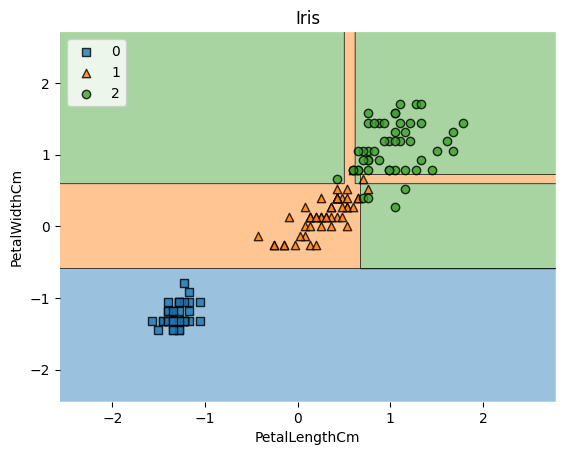

In [42]:
plot_decision_regions(x_std, y.flatten(), tree)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

###### 剪定

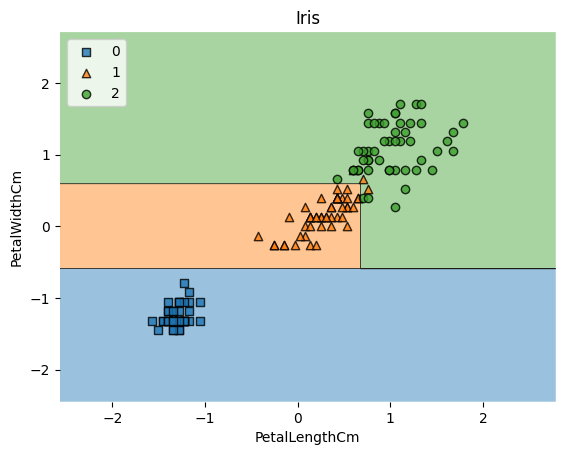

In [43]:
plot_decision_regions(x_std, y.flatten(), tree_md)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

###### ランダムフォレスト

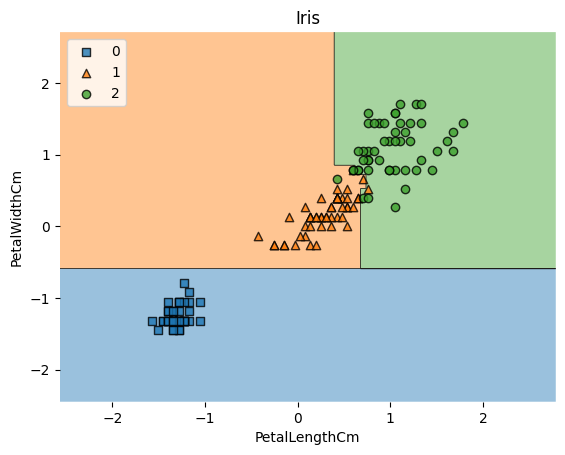

In [44]:
plot_decision_regions(x_std, y.flatten(), tree_rfc)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

###### 勾配ブースティング木

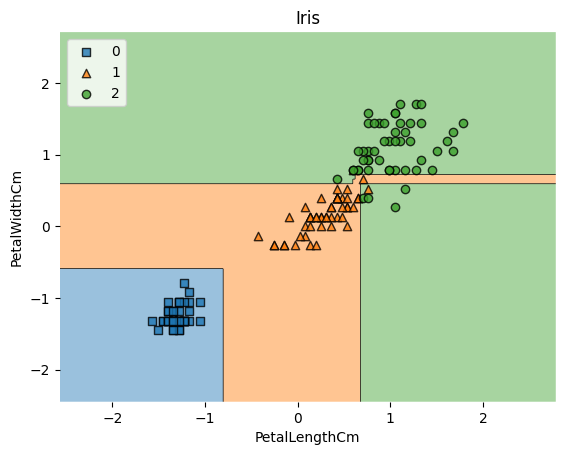

In [45]:
plot_decision_regions(x_std, y.flatten(), tree_gbc)
plt.xlabel("PetalLengthCm")
plt.ylabel("PetalWidthCm")
plt.legend(loc="upper left")
plt.title('Iris')
plt.show()

##### 予測確率を出力可能
ランダムフォレスト、勾配ブースティング木のみの機能

###### ランダムフォレスト

In [46]:
tree_rfc.predict_proba(x_test[11].reshape(1, -1))

array([[0., 1., 0.]])

###### 勾配ブースティング木

In [47]:
tree_gbc.predict_proba(x_test[11].reshape(1, -1))

array([[6.36228625e-06, 9.99969134e-01, 2.45040337e-05]])

##### 各特徴量の重要度を出力_
[ロジスティクス回帰](#ロジスティック回帰)のデータを使用するなどして（[後述](#各特徴量の重要度を出力)）。

###### 配列で表示

In [48]:
print(tree.feature_importances_)

[0.41072607 0.58927393]


###### 可視化（棒グラフ）
[ロジスティクス回帰](#ロジスティック回帰)の一番最後から実行

In [49]:
# x_columns = len(df.columns)
# plt.figure(figsize=(12, 8))
# plt.barh(range(x_columns), tree.feature_importances_ , align='center')
# plt.yticks(np.arange(x_columns), df_x.columns)
# plt.show()

### ロジスティック回帰
- 判定確率を求めることが出来る線形分類器
- 最尤推定という柔軟に最適解を求められる手法を採用

※ [イメージ](https://www.google.com/search?q=ロジスティック回帰&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#ge055200)

#### データ
２値分類専用なので、ここだけ、違うデータを使用する。

##### 生成

In [50]:
breast_cancer = datasets.load_breast_cancer()
df_data = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df_target = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])
df = pd.concat([df_data, df_target], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


##### 加工
なし

##### 理解

In [51]:
#df.columns

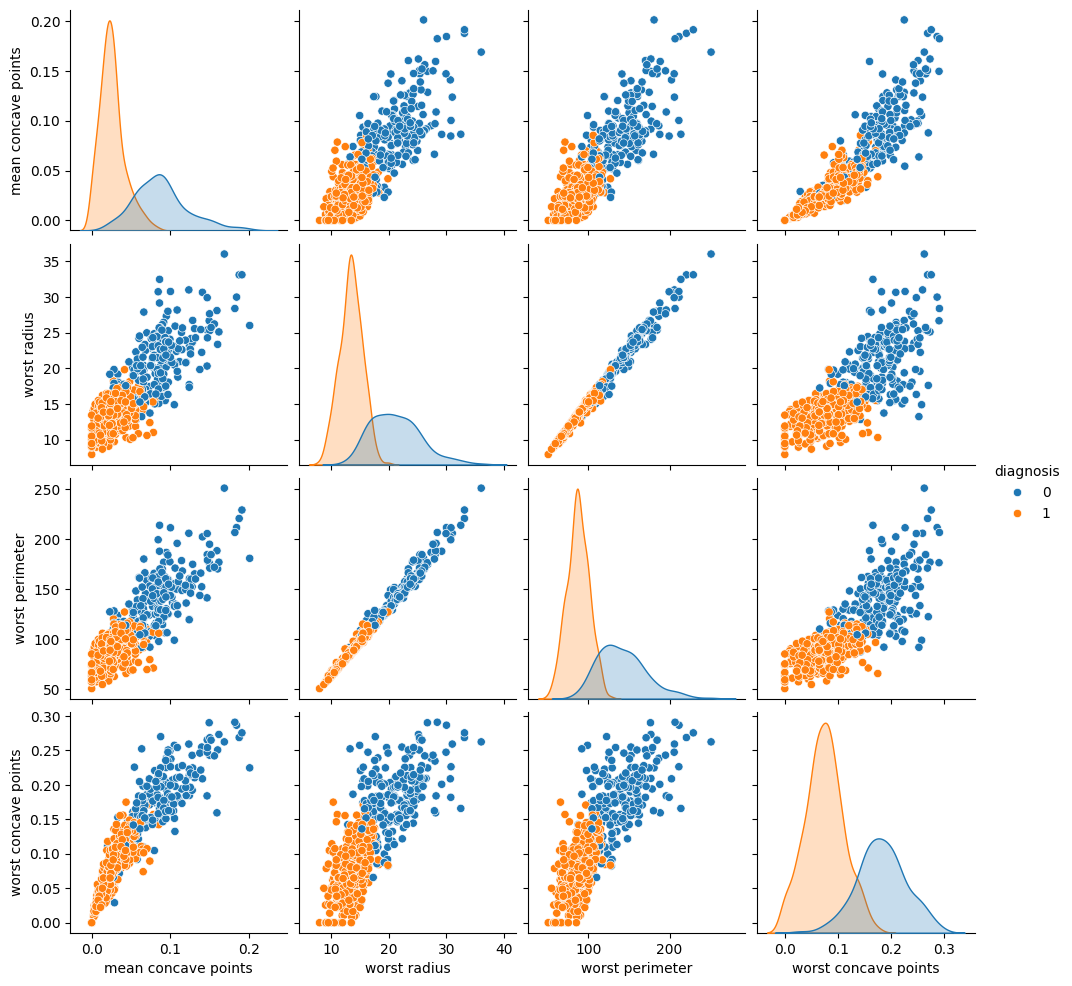

In [52]:
df_pickup = df.loc[:, ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points', 'diagnosis']]
sns.pairplot(df_pickup, hue='diagnosis')
plt.show()

##### 準備

###### 選択

In [53]:
x = df.loc[:, ['worst radius', 'worst concave points']].values
y = df.loc[:, ['diagnosis']].values

###### 標準化
カテゴリ・データは対象外

In [54]:
ss = StandardScaler()
ss.fit(x)
x_std = ss.transform(x)

###### ホールド・アウト法による学習・テストデータの分割

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=0)

#### モデリング

##### 学習

In [56]:
lr = LogisticRegression(C=1.0)
lr.fit(x_train, np.reshape(y_train,(-1)))

LogisticRegression()

##### 推論

###### 実行

In [57]:
index = 10
print('answer : %d' % y_test[index][0])
print('predict: %d' % lr.predict([x_test[index]])[0])

answer : 1
predict: 1


###### 確率

In [58]:
lr.predict_proba([x_test[index]])[0]

array([0.28833768, 0.71166232])

#### 評価

##### データセットの正答率

In [59]:
print('train acc: %.3f' % lr.score(x_train, y_train))
print('test acc: %.3f' % lr.score(x_test, y_test))

train acc: 0.947
test acc: 0.947


##### 学習した決定境界を可視化

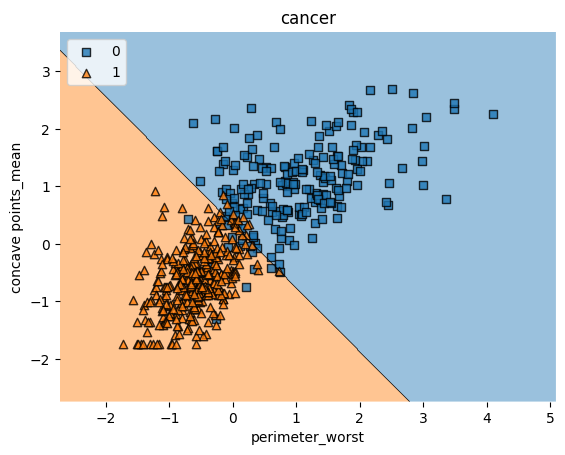

In [60]:
plot_decision_regions(x_std, y.flatten(), lr)
plt.xlabel("perimeter_worst")
plt.ylabel("concave points_mean")
plt.legend(loc="upper left")
plt.title('cancer')
plt.show()

## その他

### 各特徴量の重要度を出力
これは、RandomForestClassifierの機能

In [61]:
df_pickup_x = df_pickup.drop(['diagnosis'], axis=1)
df_pickup_y = df_pickup.loc[:, ['diagnosis']]
x = df_pickup_x.values
y = df_pickup_y.values
tree_rfc = RandomForestClassifier(random_state=0, n_estimators=100)
tree_rfc.fit(x, y)

RandomForestClassifier(random_state=0)

#### 配列で表示

##### 各特徴量

In [62]:
df_pickup_x.columns

Index(['mean concave points', 'worst radius', 'worst perimeter',
       'worst concave points'],
      dtype='object')

##### 重要度

In [63]:
print(tree_rfc.feature_importances_)

[0.15982526 0.27292512 0.333943   0.23330661]


#### 棒グラフで表示

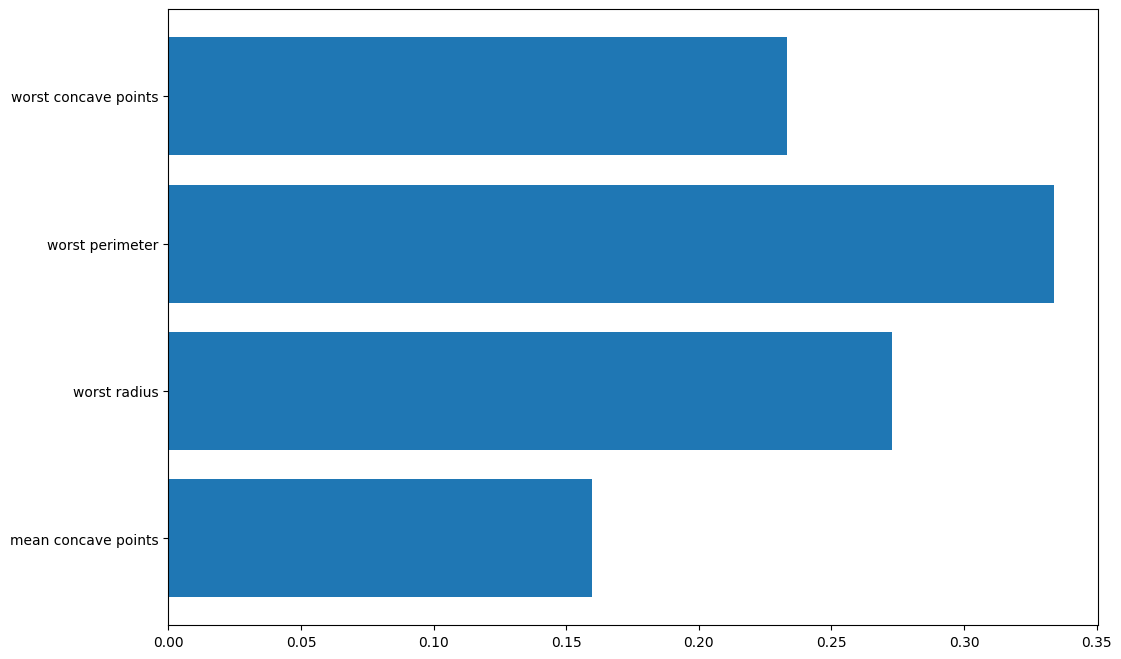

In [64]:
x_columns = len(df_pickup_x.columns)
plt.figure(figsize=(12, 8))
plt.barh(range(x_columns), tree_rfc.feature_importances_ , align='center')
plt.yticks(np.arange(x_columns), df_pickup_x.columns)
plt.show()

### [分類問題の性能の評価](ScikitLearnTraining5.ipynb)